# <center> Exercício Empírico II </center>
## <center> Econometria I - EAE0324 </center>
### <center> Junho 2022 </center>

In [86]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_palette(sns.dark_palette("#2EA3C5", reverse=True, n_colors=8))
plt.style.use(['seaborn-paper'])
pd.set_option('display.max_columns', 50)


> A questão de interesse é verificar se maus hábitos (consumo de refrigerante, horas passadas na frente da televisão e quantidade de cigarros fumada) explicam o peso dos indivíduos. Para tanto vocês terão à disposição a base da Pesquisa Nacional de Saúde (PNS) de 2013, elaborada pelo IBGE.
> 
> Todo trabalho empírico, antes de apresentar os resultados econométricos, deve apresentar algumas estatísticas descritivas.
> 
> Assim, você deve inicialmente calcular as estatísticas descritivas (média, desvio-padrão, máximo, mínimo, quantidade), por status de fumante (fumante diário, fumante ocasional e não fumante) para as variáveis que serão utilizadas na primeira regressão múltipla que você vai estimar (equação abaixo):
> 
> $$peso_g = \beta_0 + \beta_1 refrigerante_i + \beta_2 TV_i + \beta_3 cigarro_i + u_i$$
> 
> Em que peso_g é o peso do indivíduo em gramas, TV é a quantidade de horas diárias gastas assistindo televisão e cigarro é a quantidade de cigarros consumida por dia. A variável cigarro assume o valor 0 para os indivíduos que não fumam.
> 
> Comente essas estatísticas descritivas.
> 
> Estime, então, essa regressão. Interprete e comente os resultados.
> 
> Reestime a equação, com a variável dependente em log, assim como a variável cigarro. Interprete os resultados e compare com os obtidos do modelo com as variáveis em nível.
>
> $$log(peso_g) = \beta_0 + \beta_1 refrigerante_i + \beta_2 TV_i + \beta_3 log(cigarro_i) + u_i$$
>
> Que outra variável (variáveis) que faz (fazem) parte da PNS 2013 você poderia adicionar ao modelo? Reestime o modelo incluindo esta variável ou variáveis. Interprete e comente os resultados. A partir daqui você está por conta própria e deve usar seus conhecimentos de Economia e de Econometria.
> 
> O trabalho deve ter 3 páginas e ser entregue no dia 16/06.

## Descrição e Tratamento dos Dados

***

O objetivo deste exercício é estimar o efeito dos hábitos e características diversas de um indivíduo em seu peso em gramas. Para isto, usaremos os dados da PNS (Pesquisa Nacional de Saúde) de 2013. Nesta base, possuímos informações sobre os hábitos, peso, altura, sexo, estado conjugal, alfabetização e idade dos indivíduos participantes, mas antes de estimarmos o primeiro modelo de regressão, é necessário tratar os dados e conhecer mais sobre a base.


In [87]:
df = pd.read_stata("data/raw/exercicio-empirico-02.dta")
df.head()

,v0001,c006,c00701,c00702,c00703,c008,c009,c010,c011,d001,p020,p022,p045,p050,p05402,w00103,w00203,v0022
0,11,1,29,12,1977,35,2,1.0,1.0,2.0,3.0,2.0,3.0,3.0,NaN,59.500000,162.0,4
1,11,2,0,20,37,37,1,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
2,11,2,18,1,2013,0,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
3,11,2,0,20,16,16,1,2.0,5.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
4,11,1,7,11,1970,42,4,1.0,1.0,1.0,4.0,2.0,3.0,3.0,NaN,81.199997,169.0,2


Em primeiro lugar, utilizaremos o dicionário de variáveis fornecido com a base para lembrarmos os valores que serão utilizados ao longo de todo o exercício.

In [88]:
cods = ['c008', 'p020', 'p022', 'p045', 'p05402', 'w00103', 'w00203']

trad = ['Idade', 'Quantidade de Dias que Consome Refrigerante', 'Quantidade de Refrigerante Consumida', 
        'Horas assistindo TV', 'Quantidad de Cigarro/Dia', 'Peso (kg)', 'Altura (cm)']

dicio = pd.DataFrame({'Código': cods, 'Significado': trad})
display(dicio)

,Código,Significado
0,c008,Idade
1,p020,Quantidade de Dias que Consome Refrigerante
2,p022,Quantidade de Refrigerante Consumida
3,p045,Horas assistindo TV
4,p05402,Quantidad de Cigarro/Dia
5,w00103,Peso (kg)
6,w00203,Altura (cm)


</br>

O segundo passo de preparação deste exercício foi a conversão do peso em quilogramas (como foi passado na base original) para gramas e o preenchimento dos dados categóricos originais pela sua versão explicita. Ao final desse processo (cujo o código pode ser visto [aqui](https://github.com/baldoinov/econometria-i/blob/main/ex_empirico_02.ipynb)), terminamos com a seguinte base:

In [89]:
# https://stackoverflow.com/questions/64671316/convert-numerical-data-to-categorical-in-python
# https://pandas.pydata.org/docs/reference/api/pandas.cut.html
# https://stackoverflow.com/questions/20250771/remap-values-in-pandas-column-with-a-dict-preserve-nans


# Mudando Unidades
df['w00103og'] = df['w00103'].__deepcopy__()
df['w00103'] = df['w00103'] * 1000


# Tratando variáveis categóricas
d_p050 = {1: 'diariamente', 2: 'menos que diariamente', 3: 'não fumo atualmente'}  
df['p050'] = df['p050'].map(d_p050).fillna(df['p050'])

d_c006 = {1: 'masculino', 2: 'feminino'}
df['c006'] = df['c006'].map(d_c006).fillna(df['c006'])

d_c009 = {1: 'branca', 2: 'preta', 3: 'amarela', 4: 'parda', 5: 'indigena', 9: 'ignorado'}
df['c009'] = df['c009'].map(d_c009).fillna(df['c009'])

d_c010 = {1: 'vive acompanhado', 2: 'nao vive acompanhado'}
df['c010'] = df['c010'].map(d_c010).fillna(df['c010'])

d_c011 = {1: 'casado(a)', 2: 'separado(a) ou desquitado(a) judicialmente', 3: 'divorciado(a)', 4: 'viuvo(a)', 5: 'solteiro(a)'}
df['c011'] = df['c011'].map(d_c011).fillna('nao aplicavel')

d_d001 = {1: 'alfabetizado', 2: 'nao alfabetizado'}
df['d001'] = df['d001'].map(d_d001).fillna('nao aplicavel')

d_p045 = {1: 0.5, 2: 1.5, 3: 2.5, 4: 3.5, 5: 4.5, 6: 5.5, 7: 6.5, 8: 0}
df['p045'] = df['p045'].map(d_p045).fillna(0)


# Tratando Missing Values
df = df.fillna(value={'p020': 0, 'p022': 0, 'p05402': 0})


# Exibindo do Dataframe
df[['w00103', 'c008', 'p020', 'p022', 'p045', 'p05402', 'w00203']].head()

,w00103,c008,p020,p022,p045,p05402,w00203
0,59500.0,35,3.0,2.0,2.5,0.0,162.0
1,NaN,37,0.0,0.0,0.0,0.0,NaN
2,NaN,0,0.0,0.0,0.0,0.0,NaN
3,NaN,16,0.0,0.0,0.0,0.0,NaN
4,81200.0,42,4.0,2.0,2.5,0.0,169.0


</br>

Com os dados tratados, podemos ver algumas estatísticas descritivas:


In [90]:
df[['w00103', 'c008', 'p020', 'p022', 'p045', 'p05402', 'w00203']].describe().round(2)

,w00103,c008,p020,p022,p045,p05402,w00203
count,59402.00,205546.00,205546.00,205546.00,205546.00,205546.00,59402.00
mean,70403.97,32.28,0.69,0.35,0.69,0.38,163.04
std,15215.30,20.65,1.70,0.76,1.41,2.78,9.74
min,30000.00,0.00,0.00,0.00,0.00,0.00,125.00
25%,59700.00,15.00,0.00,0.00,0.00,0.00,156.00
50%,68600.00,30.00,0.00,0.00,0.00,0.00,162.80
75%,79200.00,47.00,0.00,0.00,0.50,0.00,170.00
max,179000.00,109.00,7.00,3.00,6.50,80.00,203.00


</br>

Como indicado na tabela acima, nem todas as observações da nossa base estão completas. Por exemplo, a variável de interesse, peso (w00103), só possui 59402 observações de um total de 205546 entradas. Apesar desse fato, ainda possuímos dados o suficiente para estimarmos modelos com muitos graus de liberdade. 

## Modelos de Regressão

### Modelo 01

$$peso_g = \beta_0 + \beta_1 refrigerante_i + \beta_2 TV_i + \beta_3 cigarro_i + u_i$$

In [91]:
df_reg1 = df[['w00103', 'p020', 'p045', 'p05402']].__deepcopy__()

X = df_reg1[['p020', 'p045', 'p05402']]
X = sm.add_constant(X)

Y = df_reg1['w00103']

model_01 = sm.OLS(Y, X, missing='drop')
results_01 = model_01.fit()
print(results_01.summary(title="Modelo 01 - OLS Regression Results"))

                      Modelo 01 - OLS Regression Results                      
Dep. Variable:                 w00103   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     91.56
Date:                Thu, 16 Jun 2022   Prob (F-statistic):           4.08e-59
Time:                        18:44:03   Log-Likelihood:            -6.5619e+05
No. Observations:               59402   AIC:                         1.312e+06
Df Residuals:                   59398   BIC:                         1.312e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.898e+04    120.429    572.791      0.0

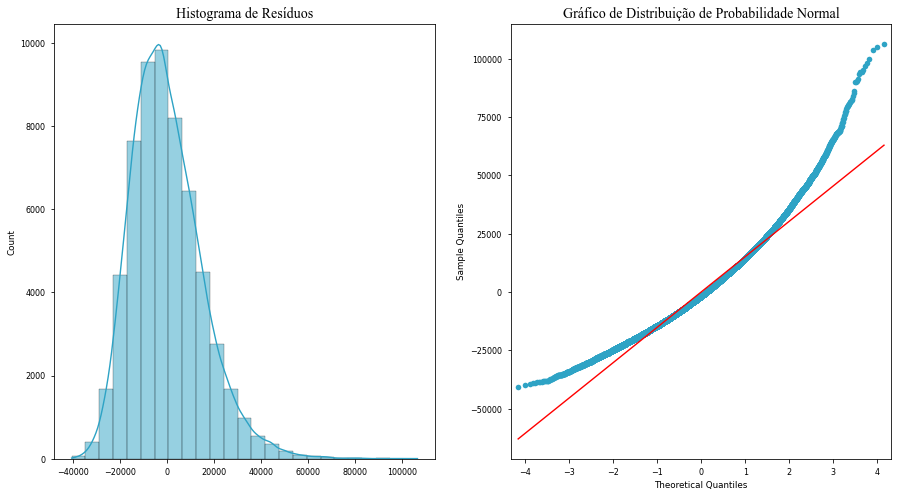

In [92]:
# https://stackoverflow.com/questions/10388462/matplotlib-different-size-subplots
# https://matplotlib.org/3.5.0/tutorials/text/annotations.html
# https://matplotlib.org/3.5.0/tutorials/text/text_intro.html

# https://stackoverflow.com/questions/42435446/how-to-put-text-outside-python-plots -> Escrever a sua resposta

u_1 = results_01.resid

fig, axes = plt.subplots(1, 2, figsize=(15, 8))

# Histograma de Residuos 
sns.histplot(x=u_1, bins=25, kde=True, ax=axes[0])
axes[0].set_title('Histograma de Resíduos', {'fontname':'Times New Roman', 'fontsize': 14})

# Grafico de Distribuição de Probabilidade Normal
import statsmodels.graphics.gofplots as gm
pnorm = gm.ProbPlot(u_1).qqplot(line='s', ax=axes[1])
axes[1].set_title('Gráfico de Distribuição de Probabilidade Normal', {'fontname':'Times New Roman', 'fontsize': 14})


plt.show()

O resultado da regressão acima nos diz que existe uma associação positiva entre o peso em gramas do indivíduo, a quantidade de dias que ele consome refrigerante ($\text{p020}$) e a quantidade de horas assistindo televisão. Isto é, *ceteris paribus*, consumir refrigerante um dia a mais na semana pode levar a um aumento do peso do indivíduo em cerca de 380 gramas, essa análise de estática comparativa pode ser extrapolada para as outras variáveis do modelo para demonstrar que uma hora a mais assistindo TV ($\text{p045}$) está associada a um ganho de 227 gramas e que o consumo de um cigarro a mais ($\text{p05402}$) está associado a uma diminuição de 9 gramas no peso do indivíduo. Segundo a tabela de resumo, o $R^2$ de $0.005$ indica que a regressão explica 0.5% da variação do peso do indivíduo em gramas. Dada a simplicidade do modelo inicial, é compreensível esse baixo poder explicativo.

Adicionalmente, para testarmos a hipótese de que cada parâmetro individual é igual a zero, isto é, $\beta_i = 0$, nós precisamos garantir que os resíduos do nosso modelo são distribuídos normalmente. É possível ver através das ferramentas gráficas acima que a distribuição do termo de erro do nosso modelo não se aproxima perfeitamente de uma distribuição normal, mas, apesar disso, prosseguiremos com o teste de hipóteses.

Os valores estimados para os nossos $\hat{\beta_i}$ são, respectivamente, $382.0815$, $227.6570$ e $-9.2446$. Através dos p-valores informados no tabela de resumo, podemos rejeitar a hipótese nula para os dois primeiros coeficientes ($\beta_1 \ne 0$ e $\beta_2 \ne 0$), mas não para o terceiro ($\beta_3$). Em suma, os resultados da nossa regressão são estatisticamente significantes ao nível de 5% para os dois primeiros coeficientes, mas não para o terceiro. Além disso, o p-valor da estatística $F$ nos mostra que os coeficientes da regressão, de forma conjunta, são estatisticamente significantes ao nível de 5%.

### Modelo 02

$$log(peso_g) = \beta_0 + \beta_1 refrigerante_i + \beta_2 TV_i + \beta_3 log(cigarro_i) + u_i$$

In [93]:
df_reg2 = df[['w00103', 'p020', 'p045', 'p05402']].__deepcopy__()

df_reg2['log_p05402'] = np.log(df_reg2['p05402'] + 1)
df_reg2['log_w00103'] = np.log(df_reg2['w00103'] + 1)


X = df_reg2[['p020', 'p045', 'log_p05402']]
X = sm.add_constant(X)

Y = df_reg2['log_w00103']

model_02 = sm.OLS(Y, X, missing='drop')
results_02 = model_02.fit()
print(results_02.summary(title="Modelo 02 - OLS Regression Results"))

                      Modelo 02 - OLS Regression Results                      
Dep. Variable:             log_w00103   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     86.61
Date:                Thu, 16 Jun 2022   Prob (F-statistic):           6.52e-56
Time:                        18:44:04   Log-Likelihood:                 8194.7
No. Observations:               59402   AIC:                        -1.638e+04
Df Residuals:                   59398   BIC:                        -1.635e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.1216      0.002   6636.866      0.0

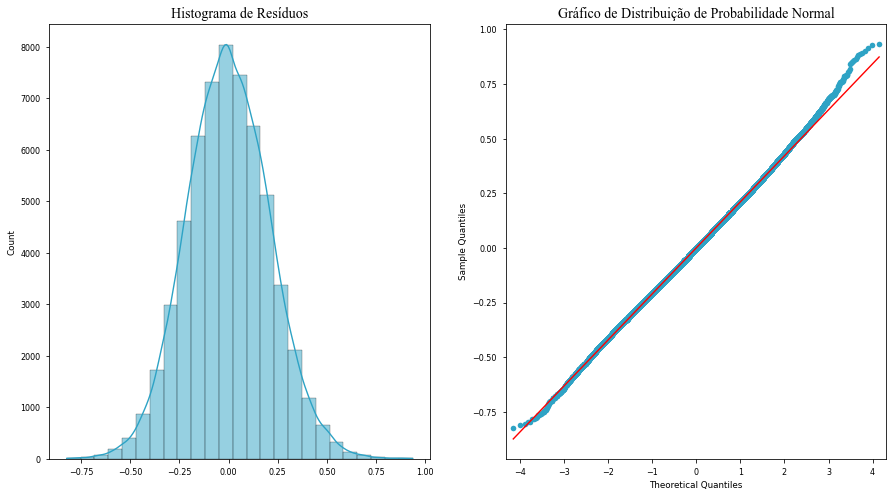

In [94]:
u_2 = results_02.resid

fig, axes = plt.subplots(1, 2, figsize=(15, 8))

# Histograma de Residuos 
sns.histplot(x=u_2, bins=25, kde=True, ax=axes[0])
axes[0].set_title('Histograma de Resíduos', {'fontname':'Times New Roman', 'fontsize': 14})

# Grafico de Distribuição de Probabilidade Normal

import statsmodels.graphics.gofplots as gm
pnorm = gm.ProbPlot(u_2).qqplot(line='s', ax=axes[1])
axes[1].set_title('Gráfico de Distribuição de Probabilidade Normal', {'fontname':'Times New Roman', 'fontsize': 14})

plt.show()

Neste segundo modelo, o uso de $logs$ na variável dependente ( $log(\text{w00103})$ ) e na variável de consumo de cigarro ( $log(\text{p05402})$ ) modifica a interpretação dos coeficientes. Para o consumo de cigarro por dia, o coeficiente de estimado nos diz que o aumento de 1% no consumo de cigarro está associado a uma diminuição de 0.0036% no peso em gramas do indivíduo. De forma *semelhante*, podemos ver que um dia a mais consumindo refrigerante leva a um aumento de 0.52% no peso em gramas da pessoa e uma hora a mais assistindo teve está associada a um aumento de 0.28% no peso do indivíduo. Semelhantemente ao primeiro modelo, o $R^2$ de $0.004$ indica que a regressão explica 0,4% da variação do $log$ do peso do indivíduo em gramas, além disso, é interessante notar que o $\overline{R^2}$ não impôs nenhuma penalidade à conversão das variáveis $\text{w00103}$ e $\text{p05402}$ para $log$.

Como podemos ver pelos p-valores informados na tabela de resumo, todos os coeficientes estimados são estatisticamente significantes ao nível de 5%, o que nos leva a rejeitar a hipótese nula de que $\beta_i = 0$ e a hipótese conjunta de que todos os parâmetros são iguais a zero. Além disso, diferentemente do primeiro modelo, podemos ver pelos gráficos acima que o termo de erro da regressão tem uma distribuição bem próxima a uma normal, o que descarta considerações extras sobre a validade do nosso teste de hipóteses.

### Modelo 03


In [95]:
df_reg3 = df[['w00103', 'c008', 'p020', 'p022', 'p045', 'p05402', 'w00203']].__deepcopy__()

df_reg3['log_p05402'] = np.log(df_reg3['p05402'] + 1)
df_reg3['log_w00103'] = np.log(df_reg3['w00103'] + 1)
df_reg3['p020_p022'] = df_reg3['p020'] * df_reg3['p022']
df_reg3['c008_2'] = df_reg3['c008'] ** 2

X = df_reg3[['c008', 'c008_2', 'p020_p022', 'p045', 'log_p05402', 'w00203']]
X = sm.add_constant(X)

Y = df_reg3['log_w00103']

model_03 = sm.OLS(Y, X, missing='drop')
results_03 = model_03.fit()
print(results_03.summary(title="Modelo 03 - OLS Regression Results"))


                      Modelo 03 - OLS Regression Results                      
Dep. Variable:             log_w00103   R-squared:                       0.295
Model:                            OLS   Adj. R-squared:                  0.295
Method:                 Least Squares   F-statistic:                     4138.
Date:                Thu, 16 Jun 2022   Prob (F-statistic):               0.00
Time:                        18:44:05   Log-Likelihood:                 18439.
No. Observations:               59402   AIC:                        -3.686e+04
Df Residuals:                   59395   BIC:                        -3.680e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.9629      0.014    635.219      0.0

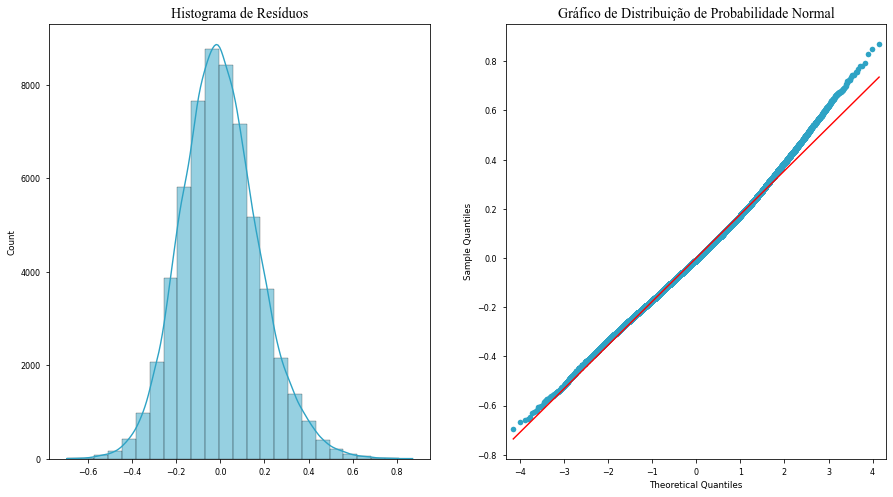

In [96]:
u_3 = results_03.resid

fig, axes = plt.subplots(1, 2, figsize=(15, 8))

# Histograma de Residuos 
sns.histplot(x=u_3, bins=25, kde=True, ax=axes[0])
axes[0].set_title('Histograma de Resíduos', {'fontname':'Times New Roman', 'fontsize': 14})

# Grafico de Distribuição de Probabilidade Normal

import statsmodels.graphics.gofplots as gm
pnorm = gm.ProbPlot(u_3).qqplot(line='s', ax=axes[1])
axes[1].set_title('Gráfico de Distribuição de Probabilidade Normal', {'fontname':'Times New Roman', 'fontsize': 14})

plt.show()

Neste terceiro e último modelo, estimamos a regressão:

$$log(\text{peso}) = \beta_0 + \beta_1 \text{idade}_i + \beta_2 \text{idade}^2 + \beta_3 (\text{p020} \times \text{p022}) + \beta_4 \text{TV}_i + \beta_5 log(\text{cigarro}_i) + \beta_6 \text{altura}_i + u_i$$

Neste modelo, a interação entre as variáveis $\text{p020}$ e $\text{p022}$ nos dá o consumo total de refrigerante pelo indivíduo na semana, e a idade ao quadrado nos mostra o efeito decrescente da idade no aumento percentual do peso.

Posto isso, esse terceiro modelo nos informa que a cada ano mais velho, um indivíduo tende a ganhar 1.34% gramas a mais. Entretanto, esse efeito atinge seu pico aos 67 anos de idade, onde os efeitos decrescentes da idade sobre o peso começam a aparecer. Analogamente, um aumento no consumo total de refrigerante do indivíduo, isto é, quantidade de refrigerantes tomados *vezes* a frequência desse consumo, está associado a um aumento de 0.12% no peso em gramas do indivíduo. O mesmo raciocinio pode ser aplicado aos coeficientes das variáveis de consumo de cigarro ($log(\text{p05402})$) e de altura ($log(\text{w00203})$).

Um ponto de notável diferença em relação aos modelos anteriores é grau de ajuste. O $R^2$ passou a explicar cerca de 30% da variação no peso em gramas dos indivíduos da amostra, isso sem sermos penalizados pela medida ajustada $\overline{R}^2$. Entretanto, cabe notar que ao incluír a variável altura podemos incorrer em um problema de multicolinearidade, dada a forte correlação entre a altura do indivíduo e seu peso.

Apesar do provável problema com multicolinearidade, o histograma de resíduos e o gráfico de distribuição de probabilidade normal expostos acima demonstram que o termo de erro do nosso modelo se aproxima bem o suficiente de uma distribuição normal. Tendo isso em mente, podemos testar sob cada parâmetro estimado a hipótese de que $\beta_i = 0$. O resultado desses testes, como é possível ver pelos p-valores da tabela de resumo, nos leva a rejeitar a hipótese nula ao nível de 5% de significância. Adicionalmente, como podemos ver pelo p-valor da estatística $F$, também podemos rejeitar a hipótese conjunta de que todos os parâmetros são iguais a zero.